In [1]:
import pandas as pd
import os
from tqdm import tqdm
import argparse
import yaml
import matplotlib.pyplot as plt
import tifffile
import seaborn as sns
import bokeh

from utils import *
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
config = yaml.safe_load(open('/Users/ursic/PhD/Projects/1_DataAnalysis_zebrafish/beads_in_zebrafish/magnetic_tweezers_SD/config.yml'))

filepath_measurements_info = config['filepath_measurements_info']
dir_plots = os.path.join(config['dir_parent'], '3_plots')  # Folder for saving plots
dir_analysis = os.path.join(config['dir_parent'], '2_analysis')  # Folder for saving analysis results
recalculate = config['recalculate']  # Whether to recalculate measurements if they already exist
pix_size = config['pix_size'] 

In [3]:
df_general_info = pd.read_csv(filepath_measurements_info, delimiter=';', encoding='utf-8')
df_general_info = df_general_info.sort_values(by='trackmate_file')
df_general_info.head()

,trackmate_file,MTs,first_pulse (frame),last_pulse (frame),t_on (frame),t_off (frame),tip_x,tip_y,calibration (mV),bead_type,time_interval (s),comments
0,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,131,251,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
1,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,169,249,10,30,98,378,1000,2.8 um myc dyna passivated PEG,0.5,NaN
2,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,13,653,10,30,53,314,1000,2.8 um myc dyna passivated PEG,0.5,NaN
3,/Volumes/cytokinesis-zebrafish-collab/magnetic...,n,11,611,10,30,57,360,1000,2.8 um myc dyna passivated PEG,0.5,"one bead stuck during pulses 7,8,9,10"
4,/Volumes/cytokinesis-zebrafish-collab/magnetic...,y,11,531,10,30,82,254,1000,2.8 um myc dyna passivated PEG,0.5,NaN


In [4]:
save_to_server = True

## Show an example of beads and tracks, visualize the end point of the tweezer tip

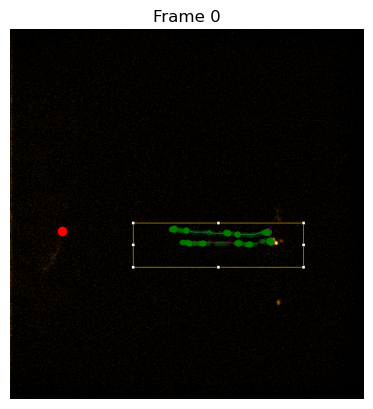

In [5]:
filepath = '/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/1_measurements/20240523/20240523_s01p01t01/TrackMate capture of 20240523_s01p01t01_1_5sON_15sOFF_1000mV-1.tif'

tip = df_general_info.loc[df_general_info['trackmate_file'].str.contains('20240523_s01p01t01_1_5sON_15sOFF'), ['tip_x', 'tip_y']].values[0]

df = pd.read_hdf('/Volumes/cytokinesis-zebrafish-collab/magnetic_tweezers_SD/2_analysis/measurements_extended_info/20240523_s01p01t01_1_5sON_15sOFF_spots_extended.h5')
tracks_x = df['POSITION_X'].values
tracks_y = df['POSITION_Y'].values

# Load the time series TIFF file
images = tifffile.imread(filepath)

# Check the shape of the images array (T, Z, Y, X) or (T, Y, X) depending on the data
# Plot the first frame of the time series
plt.figure()
plt.imshow(images[0], cmap='gray')
plt.plot(tip[0], tip[1], 'ro')
plt.plot(tracks_x/pix_size, tracks_y/pix_size, 'g.', alpha =0.2)
plt.title('Frame 0')
plt.axis('off')
plt.show()

# Calculating response parameters (model independent)

Calculating the parameters: 
- The total distance travelled during Magnet ON (rising_dif)
- Relaxation distance (relaxing_dif)
- rising_dif normalized with the average pulse force
- Relative difference between relaxing_dif and rising_dif (which is the parameter a)
  

No filtering on the data done, except for insuficient number of data points. 
  

In [6]:
dir_measurements_extended = dir_analysis+'/measurements_extended_info/'

df_results = pd.DataFrame(columns = ['exp_date', 'sample', 'position', 'embryo', 'rep', 'track_id', 'pulse_n', 'rising_dif', 'relaxing_dif', 'rising_dif_norm', 'relative_dif', 'MT_status'])

for filename in tqdm(os.listdir(dir_measurements_extended)):
    df = pd.read_hdf(dir_measurements_extended+filename, key='df')
    df = df.sort_values(by='POSITION_T')

    for track_id in df['TRACK_ID'].unique():
        track = df[df['TRACK_ID']==track_id]
        for pulse_n in track['PULSE_NUMBER'].unique():
            pulse = track[track['PULSE_NUMBER']==pulse_n]

            if not np.all(pulse['CORRECTED DISPLACEMENT [um]'].notna()):
                continue

            displacement = pulse['CORRECTED DISPLACEMENT [um]'].values
            avg_force = np.average(pulse.loc[pulse['MAGNET_STATUS']==1, 'FORCE [pN]'].values)

            rising_phase = pulse.loc[pulse['MAGNET_STATUS']==1, 'CORRECTED DISPLACEMENT [um]'].values
            relaxing_phase = pulse.loc[pulse['MAGNET_STATUS']==0, 'CORRECTED DISPLACEMENT [um]'].values
            
            rising_dif = rising_phase[-1]-rising_phase[0]
            relaxing_dif = relaxing_phase[-1]-relaxing_phase[0]

            rising_dif_norm = rising_dif/avg_force
            rising_dif_norm_inverse = 1/rising_dif_norm


            new_line = {
                'exp_date': [filename.split('_')[0]], 
                'sample': [filename.split('_')[1][0:3]], 
                'position': [filename.split('_')[1][3:6]], 
                'embryo': [filename.split('_')[0]+filename.split('_')[1][0:6]],
                'rep': [filename.split('_')[1][6:9]], 
                'track_id': track_id,
                'pulse_n': pulse_n,
                'avg_force': avg_force,
                'rising_dif': [rising_dif], 
                'relaxing_dif': [relaxing_dif], 
                'rising_dif_norm': [rising_dif_norm], 
                'rising_dif_norm_inverse': [rising_dif_norm_inverse],
                'relative_dif': [-relaxing_dif/rising_dif], 
                'MT_status': [pulse['MT_STATUS'].values[0]]
            }
            df_results = pd.concat([df_results, pd.DataFrame(new_line)])

if save_to_server:
    if not os.path.exists(f'{dir_plots}/results/'):
        os.makedirs(f'{dir_plots}/results/')
    df_results.to_csv(f'{dir_plots}/results/results_independent_analysis.csv', index=False)

100%|██████████| 24/24 [00:05<00:00,  4.06it/s]


In [ ]:
df_results.head()

,exp_date,sample,position,embryo,rep,track_id,pulse_n,rising_dif,relaxing_dif,rising_dif_norm,relative_dif,MT_status,avg_force,rising_dif_norm_inverse
0,20240621,s01,p01,20240621s01p01,t02,5,3,5.431235,-1.654144,0.144782,0.304561,n,37.513186,6.906935
0,20240621,s01,p01,20240621s01p01,t02,5,4,0.825725,0.315333,0.021826,-0.381887,n,37.831848,45.816514
0,20240621,s01,p01,20240621s01p01,t02,5,7,1.700312,-0.861260,0.043457,0.506530,n,39.126057,23.011103
0,20240621,s01,p01,20240621s01p01,t02,5,8,3.578237,0.703327,0.089441,-0.196557,n,40.006696,11.180561
0,20240621,s01,p01,20240621s01p01,t02,5,9,3.500590,-1.868374,0.085096,0.533731,n,41.136915,11.751422
